# Example 7.1: Fitting a test response and energy dissipation 
# PO-LF-LM-EL-SH

@author: rosoba

In [38]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

## Idealization of the pull-out problem
The one-dimensional idealization of the pull-out looks as follows

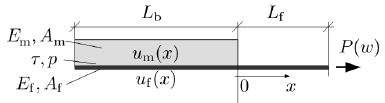

## Model parameters

The parameters and variables involved in the are grouped according geometry, material behavior, measured response, internal state and subsidiary integration parameters that will be resolved during the model derivation. In this classification we also associate the mathematical symbols with the Python variable name introduced in the next cell.

**Geometrical variables:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `A_f` | $A_\mathrm{f}$ |  Cross section area modulus of the reinforcement |
| `A_m` | $A_\mathrm{m}$ |  Cross section area modulus of the matrix |
| `p_b` | $p_\mathrm{b}$ |  Perimeter of the reinforcement                  |
| `L_b` | $L_\mathrm{b}$ |  Length of the bond zone of the pulled-out bar   |
| `x`   | $x$            |  Longitudinal coordinate |

**Material parameters:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `E_f`     | $E_\mathrm{f}$ |  Young's modulus of the reinforcement |
| `E_m`     | $E_\mathrm{m}$ |  Young's modulus of the matrix        |
| `MATS`    | $\tau(s)$      |  Multi-linear bond-slip model         |

(`MATS` is used to denote "Material Time Stepper" -- equivalent to user-subroutine in Abaqus, or user material in ATENA) 

**Control parameter:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `P` | $P$ | Pullout force |
| `w` | $w$ | pullout control  displacement

**State parameter:**

There are no state parameters included. 

 - What is the consequence? The material has no memory.
 - What happens upon unloading?

**Let's import the packages:**

In [39]:
%matplotlib notebook
import sympy as sp # symbolic algebra package
import numpy as np # numerical package
import matplotlib.pyplot as plt # plotting package
sp.init_printing() # enable nice formating of the derived expressions
import ipywidgets as ipw

## Numerical model of pull-out provided in BMCS Tool Suite 
The presented function is the simplest model provided in a general-purpose nonlinear finite-element simulator `BMCS-Tool-Suite`. This code can be installed in your anaconda environment by issuing the installation command

`pip install --upgrade bmcs`

After the installation it should be possible to import the `PullOutModel` by issuing

In [40]:
from bmcs.pullout.pullout_sim import PullOutModel
po = PullOutModel(n_e_x=60, k_max=5, w_max=1.0)
po

In [41]:
po.sim.tline.step = 0.05
po.fixed_boundary = 'loaded end (matrix)'
po.loading_scenario.trait_set(loading_type='cyclic',
                              amplitude_type='constant',
                              loading_range='non-symmetric'
                              )
po.loading_scenario.trait_set(number_of_cycles=1,
                              unloading_ratio=0.98,
                              )
po.geometry.trait_set(L_x=1.0)
po.cross_section.trait_set(A_f=1, P_b=1, A_m=1)

## Define the bond-slip law

Construct a figure to show the currently defined material model `mats` in graphic form. The data points of the bond slip law can be dfined as follows.

<IPython.core.display.Javascript object>


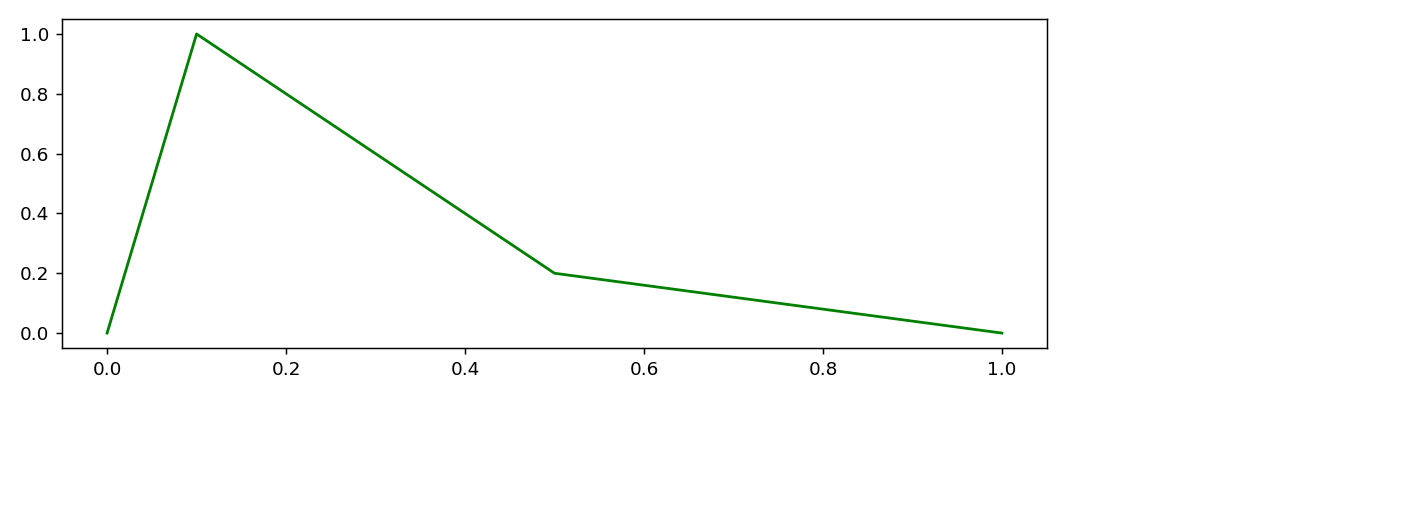

In [46]:
po.mats_eval_type = 'multilinear'
po.mats_eval.trait_set(E_m=1, E_f=1)
po.mats_eval.bs_law.trait_set(
    xdata=[0, 0.1, 0.5, 1],
    ydata=[0., 1, 0.2, 0]
)
po.mats_eval.bs_law.replot()
fix, ax = plt.subplots(1,1, figsize=(8,3),tight_layout=True)
po.mats_eval.bs_law.plot(ax, color='green')

## Run the simulation
The model object `po` contains the non-linear threaded simulator `sim` as its attribute. To be sure that the state arrays and history variables are zeroed and reset run the methods `stop` first. After that, the simulation can be started.

<IPython.core.display.Javascript object>


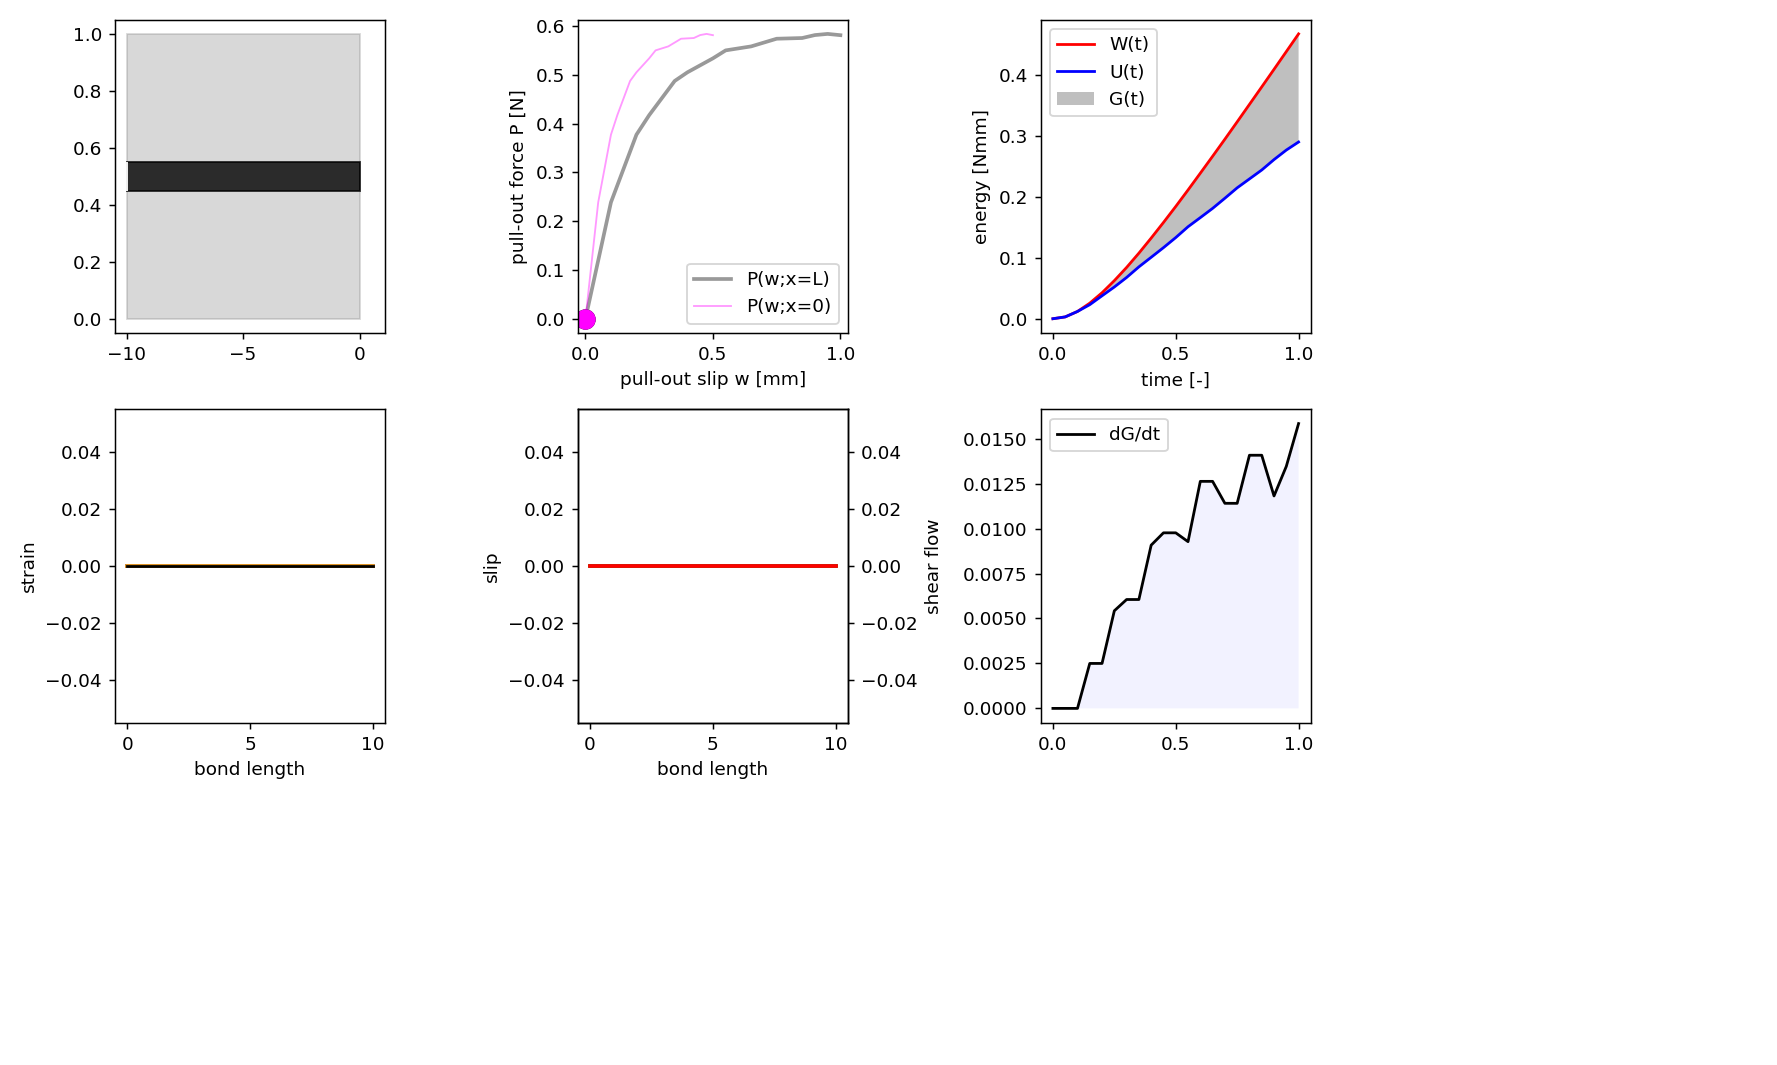

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

interactive(children=(FloatText(value=1.0, description='w_max'), FloatText(value=10.0, description='L_b'), Flo…

In [56]:
fix, ((ax_geo, ax_Pw, ax_G),
      (ax_eps, ax_s, ax_dG))= plt.subplots(2,3,figsize=(10,6),
                                   tight_layout=True)

po.sim.stop()
po.sim.run()

po.plot_geo(ax_geo, 0)
po.hist.plot_Pw(ax_Pw, 0)
po.plot_eps_p(ax_eps, 0)
po.plot_sig_p(ax_eps, 0)
po.plot_s(ax_s, 0)
po.mats_eval.bs_law.plot(ax_s)
ax_sf = ax_s.twinx()
po.plot_sf(ax_sf, 0)

def update_state(t):
    ax_geo.clear()
    po.plot_geo(ax_geo,t)
    ax_Pw.clear()
    po.hist.plot_Pw(ax_Pw,t)
    ax_eps.clear()
    po.plot_eps_p(ax_eps, t)
    ax_s.clear()
    po.plot_s(ax_s, t)
    ax_sf.clear()
    po.plot_sf(ax_sf, t)
    ax_G.clear()
    po.hist.plot_G_t(ax_G,0.9)
    ax_dG.clear()
    po.hist.plot_dG_t(ax_dG,1)

def update_material(w_max, L_b, A_f, A_m, E_f, E_m, k_max, step):
    po.w_max = w_max
    po.geometry.L_x = L_b
    po.cross_section.A_f = A_f
    po.cross_section.A_m = A_m
    po.mats_eval.E_f = E_f
    po.mats_eval.E_m = E_m
    po.k_max = k_max
    po.sim.tloop.k_max = k_max
    po.sim.tline.step = step
    po.sim.stop()
    po.sim.run()
    update_state(t_slider.value)

t_slider = ipw.FloatSlider(value=0, min=0, max=1, step=0.1)
m_sliders = dict(w_max=ipw.FloatText(value=1),
                 L_b = ipw.FloatText(value=10),
                 A_m = ipw.FloatText(value=1),
                 A_f = ipw.FloatText(value=1),
                 E_m = ipw.FloatText(value=1),
                 E_f = ipw.FloatText(value=1),
                 k_max = ipw.IntSlider(value=100, min=10, max=1000, step=20, continuous_update=False), 
                 step = ipw.FloatSlider(value=0.05, min=0.001, max=0.2, step=0.005, continuous_update=False))
ipw.interact(update_state, t=t_slider);
ipw.interact(update_material, **m_sliders );

# Rendering individual outputs

<IPython.core.display.Javascript object>


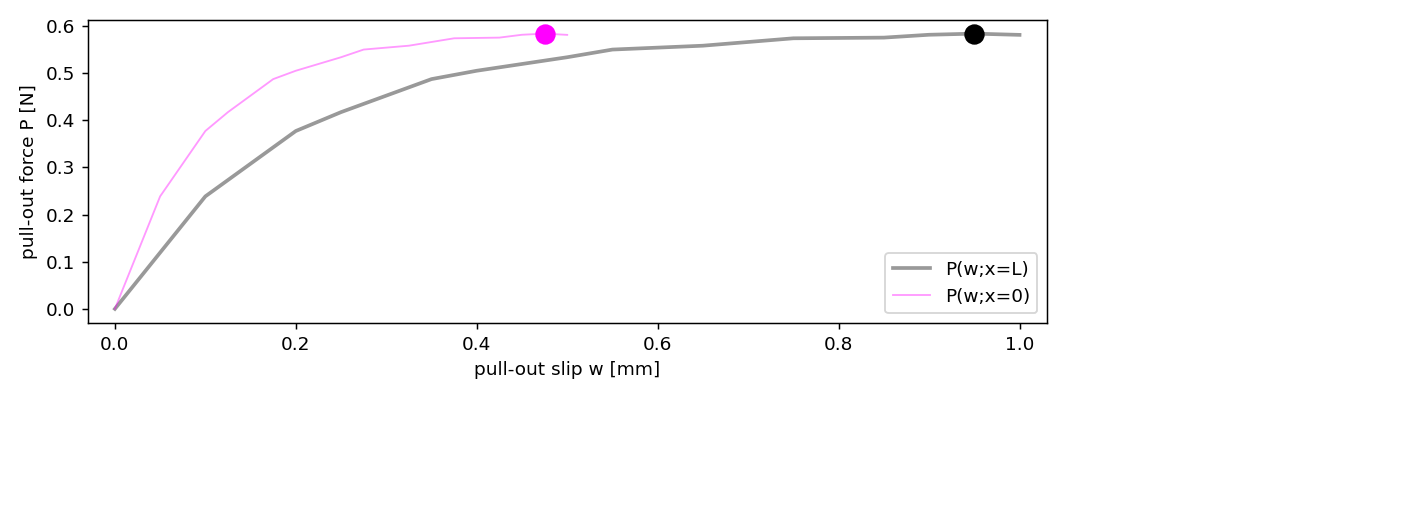

In [57]:
fix, ax = plt.subplots(1,1, figsize=(8,3),tight_layout=True)
po.hist.plot_Pw(ax,1)

All plot functions accept the scalar parameter between the start and end state in the range (0,1)

<IPython.core.display.Javascript object>


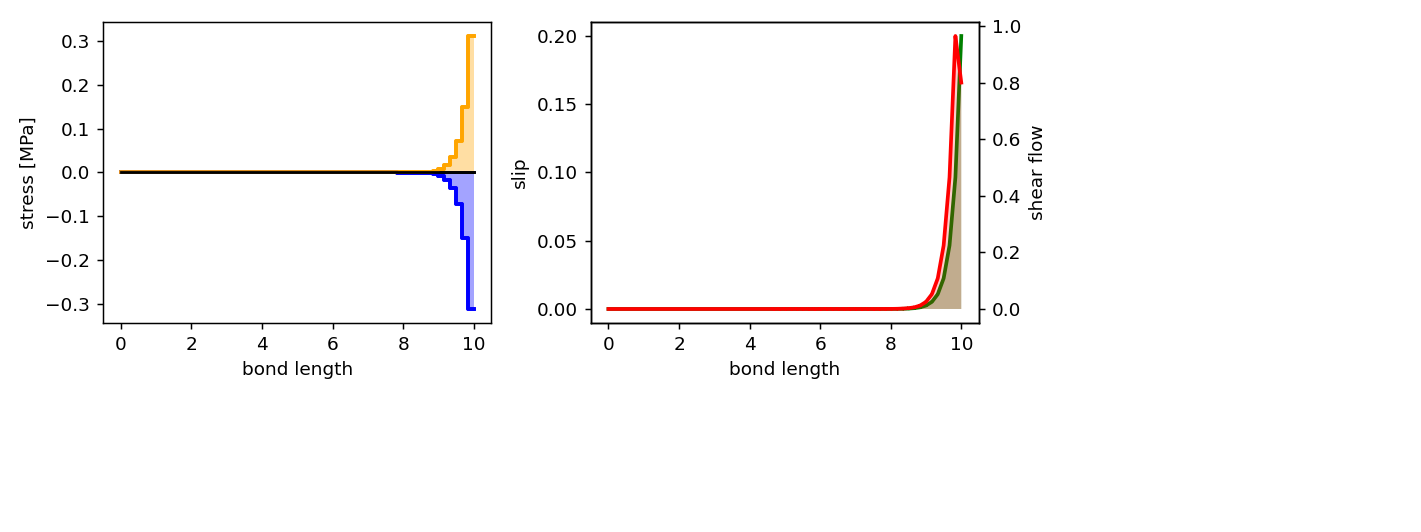

In [58]:
fix, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3),tight_layout=True)
po.plot_eps_p(ax1, 0.2)
po.plot_s(ax2, 0.2)
ax22 = ax2.twinx()
po.plot_sf(ax22, 0.2)


To use the plots of the simulations in documents, the diagrams of the above simulation
are replotted here with the goal to show the code snippets producing individual diagrams.

<IPython.core.display.Javascript object>


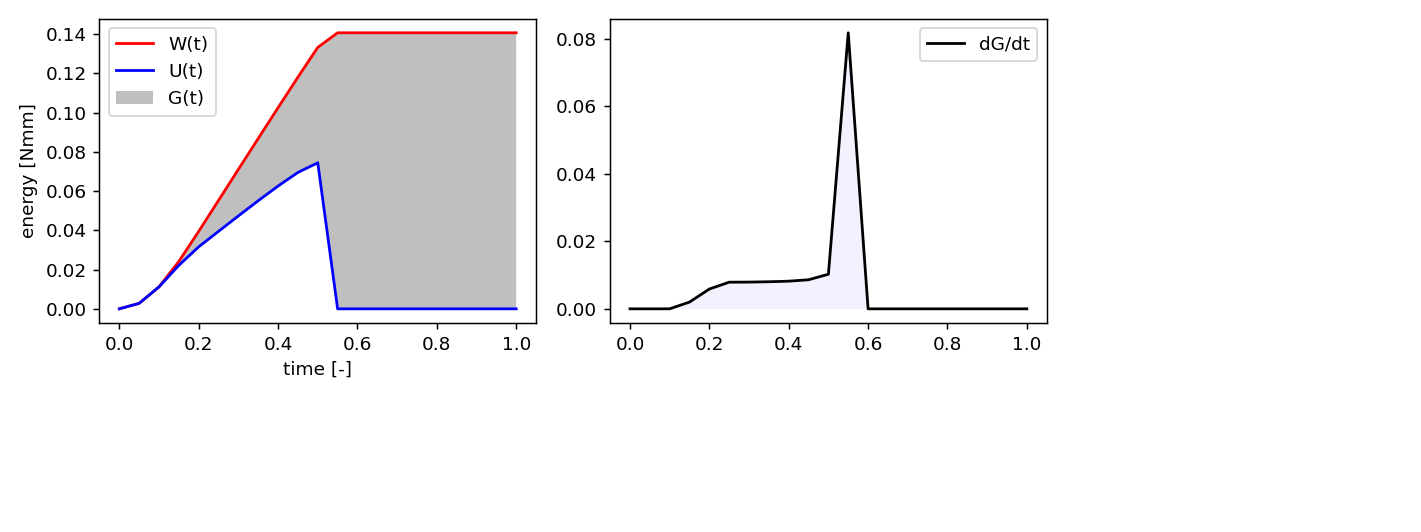

In [28]:
fix, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3),tight_layout=True)
po.hist.plot_G_t(ax1,0.9)
po.hist.plot_dG_t(ax2,1)